In [1]:
import numpy as np
import pandas as pd
import glob
import xarray as xr
import matplotlib.pyplot as plt
from scipy import stats

import sys; sys.path.insert(1, '/home/alessandro/thesis_material')
import os

import geometry as gm
#import conversion as cnv
from func_statistics import compute_pdf_nbin, slopes_r_p, slopes_r_p_onlysub, slopes_r_p_mix, slope_time, slope_maps
import regression
#from coare_functions import *
import meteo
import lcl
import metpy.calc as mpcalc
from metpy.units import units


import cartopy.crs as ccrs
crs = ccrs.PlateCarree()
#from plotmap import plot_background
from plotdistr import * #fb_distribution_npoint, perc_distribution, scatterplot_fit, hist2d
from pdist_fb_distrib_save_fast import *

import warnings; warnings.filterwarnings("ignore")

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# find data
path = '/saturn/simu_Caribbean/coupled_2km/output/'
files_ls = ['QCLOUD', 'U', 'V', 'W', 'OLR', 'PH', 'PHB', 'QVAPOR', 'PB', 'P', 'T']
files_ls = [name + '.nc' for name in files_ls]
wrf_files = [path+name for name in files_ls]
#fname_list = sorted(glob.glob(wrf_files + '*'))

In [11]:
# import sea_mask
if os.path.exists('/home/alessandro/thesis_material/EURECA_scripts/masks/sea_mask_EU_new.npy'):
    sea_mask = np.load('/home/alessandro/thesis_material/EURECA_scripts/masks/sea_mask_EU_new.npy')

In [5]:
# reading temperature
pot_temp = xr.open_dataset(wrf_files[files_ls.index('T.nc')])
pot_temp = pot_temp['T']
pot_temp = pot_temp.sel(time_counter=slice('2020-02-01T01:30:00.000000000', '2020-03-01T01:30:00.000000000'))
pot_temp = pot_temp.where(sea_mask, drop=False)
pot_temp = pot_temp.groupby('time_counter.day').mean()

T0 = 300. 

pot_temp_full = pot_temp+T0

In [34]:
# reading geopotential height
GPH_base = xr.open_dataset(wrf_files[files_ls.index('PHB.nc')])
GPH_base = GPH_base['PHB']/9.81

GPH = xr.open_dataset(wrf_files[files_ls.index('PH.nc')])
GPH = GPH.sel(time_counter=slice('2020-02-01T01:30:00.000000000', '2020-03-01T01:30:00.000000000'))
GPH = GPH['PH']/9.81

GPH = GPH_base + GPH
GPH = GPH.transpose('time_counter', 'lev_W', 'y_grid_M', 'x_grid_M')
GPH = GPH.where(sea_mask, drop=False)

GPH = GPH.groupby('time_counter.day').mean()

#GPH_base = GPH_base.where(sea_mask, drop=False)
del GPH_base

In [7]:
GPH_mean = GPH.mean(axis=(0,2,3))

In [35]:
# vertical interpolation of geopotential
GPH_inter = np.zeros_like(pot_temp)
for i in range(39):
    GPH_inter[:,i,:,:] = (GPH[:,i+1,:,:]+GPH[:,i,:,:])*0.5

NameError: name 'pot_temp' is not defined

In [9]:
# CALCULATE BRUNT VAISALA
BV_freq = mpcalc.brunt_vaisala_frequency_squared(GPH_inter*units.meters, pot_temp_full.values*units.kelvin, vertical_dim = 1)

In [100]:
GPH_mean_col = np.load('/venus/tesi_ale/data_EU/GPH/daily/FEB/GPH_mean_column.npy')

In [31]:
###   RETRIEVE PRESSURE   -  MOSTLY FOR PLOTTING

pres_base = xr.open_dataset(wrf_files[files_ls.index('PB.nc')])
pres_base = pres_base['PB']

pres = xr.open_dataset(wrf_files[files_ls.index('P.nc')])
pres = pres['P'].sel(time_counter=slice('2020-02-01T01:30:00.000000000', '2020-03-01T01:30:00.000000000'))


In [32]:
pres = (pres+pres_base)/100.                # hectoPascals
pres = pres.where(sea_mask, drop=False)

del pres_base

In [33]:
# mean base pressure over domain
mean_vert_pres = np.nanmean(pres, axis=(0,2,3))

In [ ]:
# retrieve SST, temperature, "buoyancy" and PBLH

In [5]:
wrf_hourly = path + 'Caraibes_WRF_3h_surf.nc'
ds_hourly = xr.open_dataset(wrf_hourly)
ds_hourly = ds_hourly.sel(time_counter=slice('2020-02-01T01:30:00.000000000', '2020-03-01T01:30:00.000000000'))

In [6]:
# lat and lon
lon_M = ds_hourly['nav_lon'].values
lat_M = ds_hourly['nav_lat'].values

In [13]:
sst_day = ds_hourly['SST'].groupby('time_counter.day').mean()            
sst_day = sst_day.where(sea_mask, drop=False).values; 

In [14]:
T2 = ds_hourly['T2'].groupby('time_counter.day').mean()
T2 = T2.where(sea_mask, drop=False).values

In [8]:
buoya = sst_day - T2

In [10]:
PBLH_day = ds_hourly['PBLH'].groupby('time_counter.day').mean()            
PBLH_day = PBLH_day.where(sea_mask, drop=False).values; 

In [48]:
buoya_flat = buoya[~np.isnan(buoya)].flatten()
#buoya_flat = np.sort(buoya_flat)
perc_99 = np.percentile(buoya_flat, 99); print(f'perc 99 = {perc_99}')
perc_95 = np.percentile(buoya_flat, 95); print(f'perc 95 = {perc_95}')
perc_75 = np.percentile(buoya_flat, 75); print(f'perc 75 = {perc_75}')
perc_3_5 = np.percentile(buoya_flat, 3.5); print(f'perc 3.5 = {perc_3_5}')

perc 99 = 1.313720703125
perc 95 = 1.12005615234375
perc 75 = 0.870086669921875
perc 3.5 = -0.00152587890625


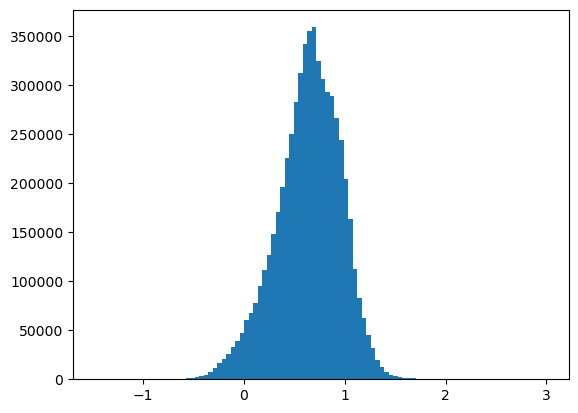

In [46]:
res= plt.hist(buoya_flat[buoya_flat<3], bins=100)
freq = res[0]/(len(buoya_flat[buoya_flat<3]))
bin_ave = 0.5*(res[1][0:-1]+res[1][1:])

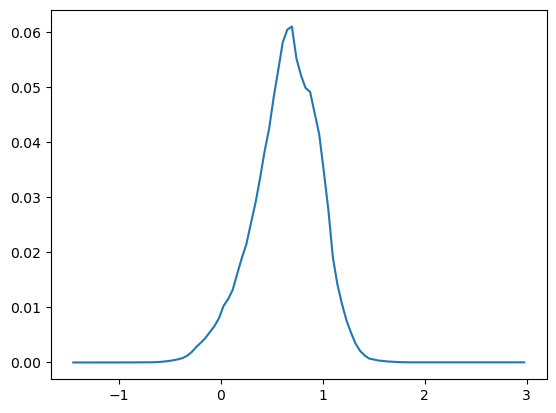

In [47]:
plt.plot(bin_ave, freq)

In [5]:
### LOAD ANOMALIES DATA FROM SAVED FILES

with open('/venus/tesi_ale/data_EU/SST/daily/FEB/dSST_day_feb.npy', 'rb') as f:
    dsst_day = np.load(f)
    
'''with open('/venus/tesi_ale/data_EU/PBLH/daily/FEB/dPBLH_day_feb.npy', 'rb') as f:
    dPBLH_day = np.load(f)'''

"with open('/venus/tesi_ale/data_EU/PBLH/daily/FEB/dPBLH_day_feb.npy', 'rb') as f:\n    dPBLH_day = np.load(f)"

In [17]:
# compute anomalies daily data
s = 100

# I want ot concentrate on heat fluxes now
# whenever want to do statistics on BV
# TURN THIS TRUE
bv = True

#dsst_day = np.zeros(sst_day.shape)
'''dbuoya_day = np.zeros(buoya.shape)'''
'''dPBLH_day = np.zeros(PBLH_day.shape)'''

if bv:
    dBV_freq_day = np.zeros(BV_freq.shape)

for t in range(0,sst_day.shape[0]):
    if t % 10 == 0:
        print(t)
    
    #sst_ave = gm.nan_gaussian_filter(sst_day[t],s)                             
    #dsst_day[t] = sst_day[t] - sst_ave
    
    '''buoya_ave = gm.nan_gaussian_filter(buoya[t],s)                             
    dbuoya_day[t] = buoya[t] - buoya_ave'''
    
    '''pbl_ave = gm.nan_gaussian_filter(PBLH_day[t],s)                             
    dPBLH_day[t] = PBLH_day[t] - pbl_ave'''
    
    if bv:
        for h in range(0,BV_freq.shape[1]):
            bv_ave = gm.nan_gaussian_filter(BV_freq[t,h].magnitude,s)                               
            dBV_freq_day[t,h] = BV_freq[t,h].magnitude - bv_ave

0
10
20


In [18]:
my_save_data('/venus/tesi_ale/data_EU/BV/daily/FEB/dBV_day_feb.npy', [dBV_freq_day])

In [6]:
##### OTHERWISE LOAD THEM FROM THE FILES  ######
with open('/venus/tesi_ale/data_EU/SST/daily/FEB/dsst_day_feb.npy', 'rb') as f:
    dsst_day = np.load(f)

# with open('/venus/tesi_ale/data_EU/PBLH/daily/FEB/dPBLH_day_feb.npy', 'rb') as f:
#     dPBLH_day = np.load(f)

FileNotFoundError: [Errno 2] No such file or directory: '/venus/tesi_ale/data_EU/SST/daily/FEB/dsst_day_feb.npy'

In [26]:
# compute distributions

(29, 546, 573)

In [25]:
# MATTE AVEVA GIA' CALCOLATO TUTTE LE CORRELAZIONI 
# E HA STIMATO QUESTA LUNGHEZZA?
L = 30
nskip = int(L/2)
nt = int(1)

# from top pbl upwards
# SOPRA PBL LA LUNGEHZZA DI CORRELAZIONE AUMENTA?
# NEL SENSO CHE I SEGNALI HANNO PIù SPAZIO PER PROPAGARSI?
Ltop = 150
nskiptop = int(Ltop/2)
nttop = int(1)

# reference population mean
popmean = 0.

In [21]:
# PERC DISTRIBUTION dBV_fre vs dSST bin - DAILY + PVALUE SUBSAMPLED height dependent
perc_step = 5
nbins = int(100/perc_step) # Number of bins.

pdist_dsst_day, pdist_dBV_freq_day, pstd_dBV_freq_day, pstderr_dBV_freq_day, pnpoints_dBV_freq_day, ppvalue_dBV_freq_day_sub = \
dist_3d_subsample(dsst_day, dBV_freq_day, perc_step, nbins, popmean, nt, nttop, nskip, nskiptop, top=14, perc_fixbin='perc')

0
10
20
30


In [22]:
# PERC DISTRIBUTION BV_fre vs dSST bin - DAILY + PVALUE SUBSAMPLED height dependent
perc_step = 5
nbins = int(100/perc_step) # Number of bins.

pdist_dsst_day, pdist_BV_freq, pstd_BV_freq, pstderr_BV_freq, pnpoints_BV_freq, ppvalue_BV_freq_sub = \
dist_3d_subsample(dsst_day, BV_freq.magnitude, perc_step, nbins, popmean, nt, nttop, nskip, nskiptop, top=14, perc_fixbin='perc')

0
10
20
30


In [ ]:
# FIXED BIN DISTRIBUTIONS

In [19]:
'''# FB DISTRIBUTION dBV_freq vs dSST bin - DAILY + PVALUE subsampled

perc_step = 5
nbins = int(100/perc_step) # Number of bins.
popmean = 0

dist_dsst_day, dist_dBV_freq_day, std_dBV_freq_day, stderr_dBV_freq_day, npoints_dBV_freq_day, pvalue_dBV_freq_day_sub = \
dist_3d_subsample(dsst_day, dBV_freq_day, perc_step, nbins, popmean, nt, nttop, nskip, nskiptop, top=14, perc_fixbin='fb')'''

0
10
20
30


In [104]:
'''# FB DISTRIBUTION BV vs dSST bin - DAILY + PVALUE subsampled
perc_step = 5
nbins = int(100/perc_step) # Number of bins.

dist_dsst_day, dist_BV_freq, std_BV_freq, stderr_BV_freq, npoints_BV_freq, pvalue_BV_freq_sub = \
dist_3d_subsample(dsst_day, BV_freq.magnitude, perc_step, nbins, popmean, nt, nttop, nskip, nskiptop, top=14, 'fb')'''

0
10
20
30


In [23]:
p_dsst_dBV = [pdist_dsst_day, pdist_dBV_freq_day, pstd_dBV_freq_day, pstderr_dBV_freq_day, pnpoints_dBV_freq_day, ppvalue_dBV_freq_day_sub]
my_save_data('/venus/tesi_ale/data_EU/BV/daily/FEB/pdistrs_dSST_dBV_day_feb.npy', p_dsst_dBV)

p_dsst_BV = [pdist_dsst_day, pdist_BV_freq, pstd_BV_freq, pstderr_BV_freq, pnpoints_BV_freq, ppvalue_BV_freq_sub]
my_save_data('/venus/tesi_ale/data_EU/BV/daily/FEB/pdistrs_dSST_BV_day_feb.npy', p_dsst_BV)


In [ ]:
# correlations with PBLH

In [24]:
wrf_hourly = path + 'Caraibes_WRF_3h_surf.nc'
ds_hourly = xr.open_dataset(wrf_hourly)
ds_hourly = ds_hourly.sel(time_counter=slice('2020-02-01T01:30:00.000000000', '2020-03-01T01:30:00.000000000'))

In [25]:
PBLH_day = ds_hourly['PBLH'].groupby('time_counter.day').mean()
PBLH_day = PBLH_day.where(sea_mask, drop=False).values;

In [28]:
dPBLH_day = np.zeros(PBLH_day.shape)

for t in range(0,sst_day.shape[0]):
    if t % 10 == 0:
        print(t)
    PBLH_ave = gm.nan_gaussian_filter(PBLH_day[t],s)
    dPBLH_day[t] = PBLH_day[t] - PBLH_ave

0
10
20


In [ ]:
# LOAD DATA HERE

with open('/venus/tesi_ale/data_EU/PBLH/daily/FEB/dPBLH_day_feb.npy', 'rb') as f:
    dPBLH_day = np.load(f)

In [20]:
### CAN BE LOADED BELOW

# PERC DISTRIBUTION 
perc_step = 5
nbins = int(100/perc_step) # Number of bins.

# # dPBLH vs dSST - DAILY
# pdist_dsst_day, pdist_dPBLH_day, pstd_dPBLH_day, pstderr_dPBLH_day, pnpoints_dPBLH_day, ppvalue_dPBLH_day = \
# distrib_2d(dsst_day, dPBLH_day, perc_step, nbins, popmean, 'perc')

# dSST vs PBLH 
pdist_dsst, pdist_PBLH_dsst, pstd_PBLH_dsst, pstd_err_PBLH_dsst, pnpoints_PBLH_dsst, ppvalue_PBLH_dsst = \
distrib_2d(dsst_day, PBLH_day, perc_step, nbins, popmean, perc_fixbin='perc')


In [21]:
# FB DISTRIBUTION dPBLH vs dSST bin - DAILY 
perc_step = 5
nbins = int(100/perc_step) # Number of bins.

'''# dSST vs PBLH 
dist_dsst, dist_PBLH_dsst, std_PBLH_dsst, std_err_PBLH_dsst, npoints_PBLH_dsst, pvalue_PBLH_dsst = \
distrib_2d(dsst_day, PBLH_day, perc_step, nbins, popmean, perc_fixbin='fb')
'''

In [26]:
### LOAD DISTRIBUTIONS FROM SAVED FILES
# saved variables are 
# pdist_dsst, pdist_PBLH_dsst, pstd_PBLH_dsst, pstderr_PBLH_dsst, pnpoints_PBLH_dsst, ppvalue_PBLH_dsst
with open('/venus/tesi_ale/data_EU/PBLH/daily/FEB/pdistrs_PBLH_dSST_day_feb.npy', 'rb') as f:
    pdist_dsst = np.load(f)
    pdist_PBLH_dsst = np.load(f)
    f.close()

/venus/tesi_ale/img_EU/BV/daily/FEB/pdist_dsst_BV_lowtropo.png


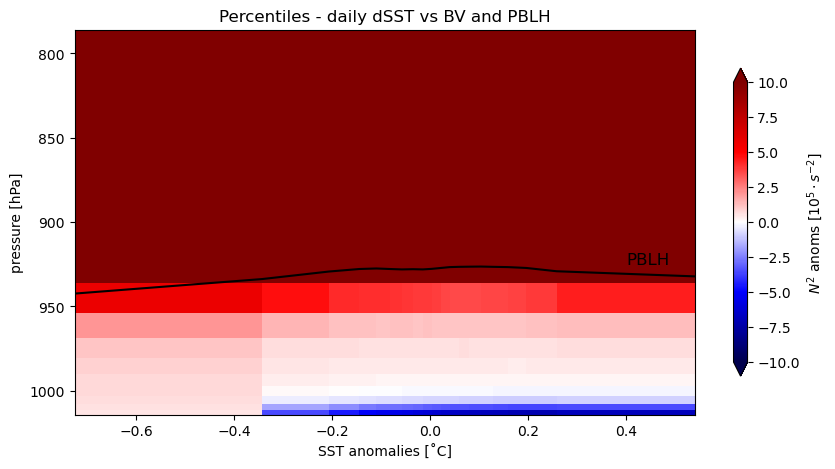

In [45]:
# figure dBV or BV vs dSST bin - DAILY
p_level_plot = int(15)

perc = True
x = pdist_dsst_day #if perc else dist_dsst_day
var = pdist_BV_freq[0:p_level_plot,:]*100000 #if perc else dist_dBV_freq_day[0:p_level_plot,:]*100000
minval = -10. #if perc else -0.05
maxval = -minval
title = 'Percentiles' #if perc else 'Fixed bins'

fig, ax1 = plt.subplots(figsize=(10, 5))  
ax1.invert_yaxis()
p1 = ax1.pcolormesh(x, mean_vert_pres[0:p_level_plot], var, vmin=minval, vmax=maxval, cmap='seismic')
ax1.set_xlabel('SST anomalies [˚C]'); ax1.set_ylabel('pressure [hPa]')
plt.title(f'{title} - daily dSST vs BV and PBLH')
cbar = plt.colorbar(p1,ax=ax1, location='right', shrink=0.8, extend='both')  
cbar.set_label('$N^2$ anoms [$10^5 \cdot s^{-2}$]')


x_pbl = pdist_dsst #if perc else dist_dsst
var_pbl = pdist_PBLH_dsst #if perc else dist_PBLH_dsst
ax1.plot(x_pbl, var_pbl, 'k')
ax1.text(0.4, 925, 'PBLH', fontsize=12)



# DEF punti significativi (pvalue < 0.05)
pval = ppvalue_dBV_freq_day_sub[0:p_level_plot] #if perc else pvalue_dBV_freq_day_sub[0:p_level_plot]
GPbin = mean_vert_pres[1:p_level_plot] - np.diff(mean_vert_pres[0:p_level_plot])*0.5
signif_Lcorr_H = np.zeros((len(mean_vert_pres[0:p_level_plot])-1,len(x)-1))
dsstbin = np.zeros((len(mean_vert_pres[0:p_level_plot])-1,len(x)-1))
for h in range(0,len(mean_vert_pres[0:p_level_plot])-1):
    cond1 = pval[h,:-1] > 0.05
    cond2 = np.abs(var[h,:-1]) < 0.1*np.nanmean(np.abs(var))
    cond = (cond1) | (cond2)
#     cond = cond1
    signif_Lcorr_H[h,:] = np.zeros(len(x)-1) + np.nan
    signif_Lcorr_H[h, cond] = GPbin[h]
    dsstbin[h,:] = x[1:] - np.diff(x)*0.5
    
plt.scatter(dsstbin,signif_Lcorr_H,  s=0.7, color='k')


path_img = '/venus/tesi_ale/img_EU/BV/daily/FEB/' if perc else '/venus/tesi_ale/img_EU/BV/daily/FEB/'
filename = path_img + 'pdist_dsst_dBV_lowtropo.png' if perc else path_img + 'bins_dsst_dBV_lowtropo.png'
#plt.savefig(filename)
print(filename)
del filename

In [18]:
#########    LOAD SST AND PBLH DISTRIBUTIONS  ########
with open('/venus/tesi_ale/results_EU/distributions/FEB/perc/PBLH/pdistrs_dPBLH_dsst_day_feb.npy', 'rb') as f:
    pdist_dsst       = np.load(f, allow_pickle=True)
    pdist_dPBLH_dsst = np.load(f, allow_pickle=True)
    pstd_PBLH_dsst   = np.load(f, allow_pickle=True)

with open('/venus/tesi_ale/results_EU/distributions/FEB/fix_bin/PBLH/distrs_dPBLH_dsst_day_feb.npy', 'rb') as f:
    dist_dsst       = np.load(f, allow_pickle=True)
    dist_dPBLH_dsst = np.load(f, allow_pickle=True)
    std_PBLH_dsst   = np.load(f, allow_pickle=True)


OSError: Failed to interpret file <_io.BufferedReader name='/venus/tesi_ale/results_EU/distributions/FEB/perc/PBLH/pdistrs_dPBLH_dsst_day_feb.npy'> as a pickle

In [12]:
np.nanmax(pstd_PBLH_dsst)

0.1445503341416252

In [ ]:
#######   SEE BEHAVIOUR OF SURFACE HEAT FLUXES

In [ ]:
dsst_sg = np.load('/venus/tesi_ale/data_EU/SST/daily/FEB/dsst_day_strongGrads.npy')

In [15]:
#LH = ds_hourly['LH'].groupby('time_counter.day').mean()            
#LH = LH.where(sea_mask, drop=False).values; 

HFX = ds_hourly['HFX'].groupby('time_counter.day').mean()            
HFX = HFX.where(sea_mask, drop=False).values; 

In [14]:
# this should be the Bowen ratio at the surface
heat_ratio = LH/HFX
heat_ratio[HFX==0] = 999.

In [ ]:
# heat anomalies

In [17]:
s = 100

#dLH = np.zeros(LH.shape)
dHFX = np.zeros(HFX.shape)

for t in range(0,LH.shape[0]):
    if t % 10 == 0:
        print(t)
    # upscale using gaussian filter
    '''LH_ave = gm.nan_gaussian_filter(LH[t],s)                             
    dLH[t] = LH[t] - LH_ave'''
    
    HFX_ave = gm.nan_gaussian_filter(HFX[t],s)                             
    dHFX[t] = HFX[t] - HFX_ave

0
10
20


In [24]:
my_save_data('/venus/tesi_ale/data_EU/LH/daily/FEB/dLH_day_feb.npy', [dLH])
my_save_data('/venus/tesi_ale/data_EU/HFX/daily/FEB/dHFX_day_feb.npy', [dHFX])

file already exists - DELETING IT and creating it anew
file already exists - DELETING IT and creating it anew


In [ ]:
# DISTRIBUTIONS

In [9]:
perc_step = 5
nbins = int(100/perc_step) # Number of bins.
popmean = 0

In [ ]:
# visualizing 

In [16]:
with open('/venus/tesi_ale/data_EU/SST/daily/FEB/dSST_day_feb.npy', 'rb') as f:
    dsst_day = np.load(f)
    
'''with open('/venus/tesi_ale/data_EU/LH/daily/FEB/dLH_day_feb.npy', 'rb') as f:
    dLH = np.load(f)'''
    
with open('/venus/tesi_ale/data_EU/HFX/daily/FEB/dHFX_day_feb.npy', 'rb') as f:
    dHFX = np.load(f)

In [19]:
strongGrads = True

if strongGrads:
    LH_sg, dLH_sg = LH*sg_mask, dLH*sg_mask

In [61]:
2*(1 - stats.t.cdf(t_LH_sst[470,170],df=27))

0.014013412074487919

In [59]:
t_value

2.8834757882772455

In [57]:
t_LH_sst[470,170]


2.6273701066280557

/venus/tesi_ale/img_EU/LH/daily/FEB/pointRegr_LH-sst_dLH-dsst_Hatch_feb.png


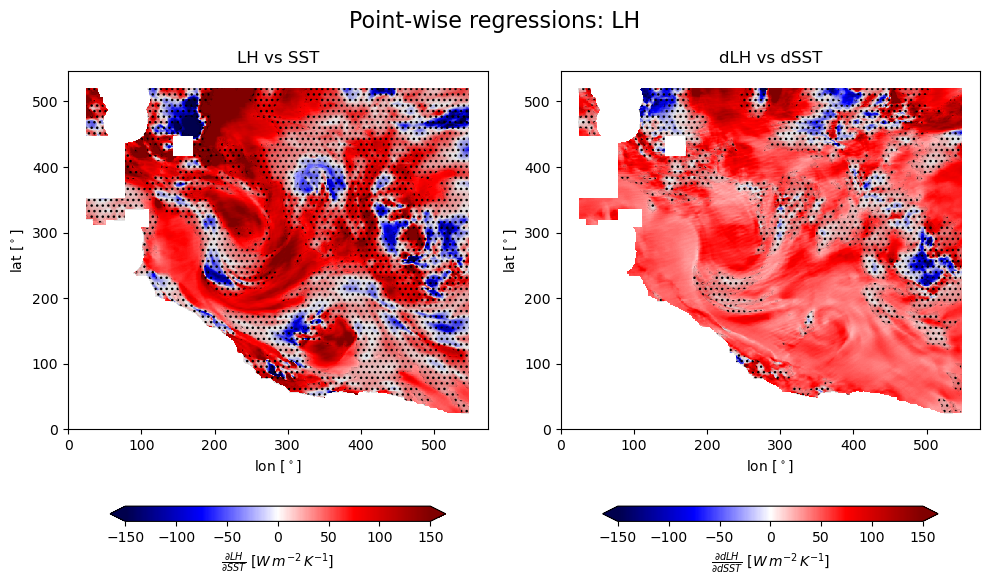

In [61]:
##### POINTWISE REGRESSIONS
import matplotlib as mpl

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,6))


x = (sst_day-273.15)        #np.transpose((sst_day-273.15), (0, 2, 1))   
y = LH                      #np.transpose(LH, (0, 2, 1))

#n_LH_sst, slope_LH_sst, intercept_LH_sst, cor_pearson_LH_sst, cor_spear_LH_sst, p_val_pearson_LH_sst, p_val_spear_LH_sst,\
#r_square_LH_sst, rmse_LH_sst = regression.MY_point_regr(x,y) 

p1 = ax1.pcolormesh(slope_LH_sst, vmin=-150, vmax=150, cmap='seismic')

cbar1 = plt.colorbar(p1,ax=ax1, location='bottom', shrink=0.8, extend='both')  
cbar1.set_label(r'$\frac{\partial LH}{\partial SST}$ [$W\,m^{-2}\,K^{-1}$]')
ax1.set_title('LH vs SST'); ax1.set_xlabel('lon [$^\circ$]'); ax1.set_ylabel('lat [$^\circ$]')

# Hatching for p-values less than 0.05
'''lat_hatch = lat_M[p_val_LH_sst > 0.05]
lon_hatch = lon_M[p_val_LH_sst > 0.05]
ax1.scatter(lon_hatch, lat_hatch, s=0.01, color='k')'''

hatch_mask = np.zeros_like(slope_LH_sst)
hatch_mask[p_val_spear_LH_sst > 0.05] = 1
cont1 = ax1.contourf(hatch_mask, levels=[0.9, 1.1], hatches=['...', None],  colors='none', alpha=0.1)



    ########
    
xx = dsst_day         #np.transpose(dsst_day, (0, 2, 1))
yy = dLH              #np.transpose(dLH, (0, 2, 1))

#n_dLH_dsst, slope_dLH_dsst, intercept_dLH_dsst, cor_pearson_dLH_dsst, cor_spear_dLH_dsst, p_val_pearson_dLH_dsst, p_val_spear_dLH_dsst,\
#r_square_dLH_dsst, rmse_dLH_dsst = regression.MY_point_regr(xx,yy)

p2 = ax2.pcolormesh(slope_dLH_dsst, vmin=-150, vmax=150, cmap='seismic')
ax2.set_title('dLH vs dSST'); ax2.set_xlabel('lon [$^\circ$]'); ax2.set_ylabel('lat [$^\circ$]')

cbar2 = plt.colorbar(p2,ax=ax2, location='bottom', shrink=0.8, extend='both')  
cbar2.set_label(r'$\frac{\partial dLH}{\partial dSST}$ [$W\,m^{-2}\,K^{-1}$]')

# Hatching for p-values less than 0.05
dhatch_mask = np.zeros_like(slope_dLH_dsst)
dhatch_mask[p_val_spear_dLH_dsst > 0.05] = 1
cont2 = ax2.contourf(dhatch_mask, levels=[0.9, 1.1], hatches=['...'], colors='none', alpha=0.1)




fig.suptitle("Point-wise regressions: LH", fontsize=16)
plt.tight_layout()

path_img = '/venus/tesi_ale/img_EU/LH/daily/FEB/' 
filename = path_img + 'pointRegr_LH-sst_dLH-dsst_Hatch_feb.png'
#plt.savefig(filename)
print(filename)
del filename

(29, 546, 573)

Text(0, 0.5, 'lat [deg]')

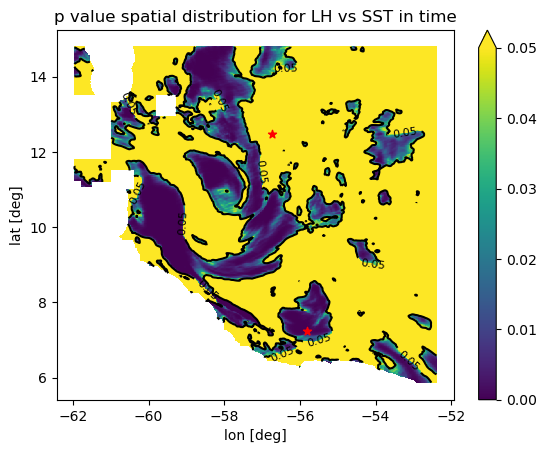

In [54]:
p = plt.pcolormesh(lon_M, lat_M, p_val_LH_sst, vmin=0, vmax=0.05, cmap='viridis')
plt.colorbar(p, extend='max')

points_lon = [lon_M[100, 360], lon_M[390, 310]] #, lon_M[200,395] ];   
points_lat = [lat_M[100, 360], lat_M[390, 310]] #, lat_M[200,395] ]
plt.scatter(points_lon, points_lat, marker='*', color='red')
contour = plt.contour(lon_M, lat_M, p_val_LH_sst, levels=[0.05], colors='black')
plt.clabel(contour, inline=True, fontsize=8)

plt.title('p value spatial distribution for LH vs SST in time')
plt.xlabel('lon [deg]'); plt.ylabel('lat [deg]')

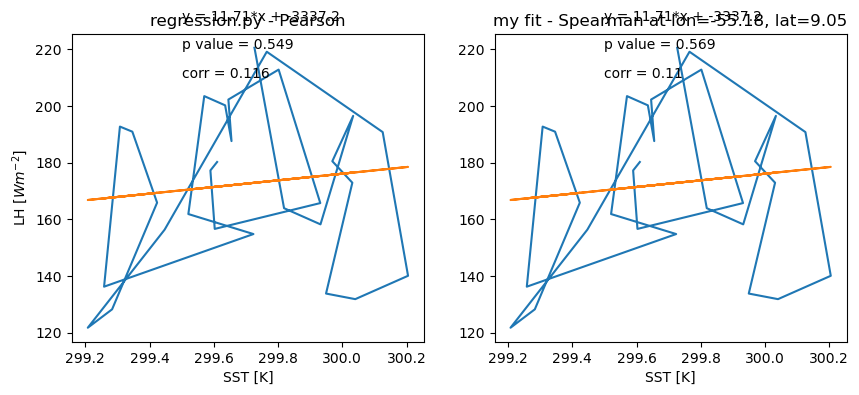

In [53]:
# UNDERSTAND WHAT IS GOING ON
# STEP BY STEP

# lat   lon
# 100   360
# 310   390
# 200   390

pos_lon = int(395)
pos_lat = int(200)


x_array = sst_day[:,pos_lat,pos_lon]
y_array = LH[:,pos_lat,pos_lon]

# Compute the number of non-nan over each (lat,lon) grid box.
n=np.sum(~np.isnan(x_array),axis=0)

# Compute mean and standard deviation of time series of x_array and y_array over each (lon,lat) grid box.
x_mean=np.nanmean(x_array,axis=0)
y_mean=np.nanmean(y_array,axis=0)
x_std=np.nanstd(x_array,axis=0)
y_std=np.nanstd(y_array,axis=0)

# Compute co-variance between time series of x_array and y_array over each (lon,lat) grid box.
cov=np.nansum((x_array-x_mean)*(y_array-y_mean),axis=0)/n

# Compute correlation coefficients between time series of x_array and y_array over each (lon,lat) grid box.
# IN FUNC_STATISTICS.PY I used this to compute correlation
# the two methods return significantly different results
# so much so that one point is considered pval<5% with one
# and pval>5% with the other method
# corr_coeff, trash = stats.spearmanr(x,y)
# PEARSON COEFFICIENT
cor=cov/(x_std*y_std)

# Compute slope between time series of x_array and y_array over each (lon,lat) grid box.
slope=cov/(x_std**2)

# Compute intercept between time series of x_array and y_array over each (lon,lat) grid box.
intercept=y_mean-x_mean*slope

# Compute tstats, stderr, and p_val between time series of x_array and y_array over each (lon,lat) grid box.
df = n-2
t_value = np.abs(cor)*np.sqrt( (df)/(1-cor**2) )
p_val = 2*(1 - stats.t.cdf(t_value,df=df))



fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,4))

text_pos = 299.5

ax1.plot(x_array, y_array, '-')
ax1.plot(x_array, slope*x_array+intercept)
ax1.text(text_pos, 230, f"y = {round(slope,2)}*x + {round(intercept,2)}")
ax1.text(text_pos, 220, f"p value = {round(p_val,3)}")
ax1.text(text_pos, 210, f"corr = {round(cor,3)}")
ax1.set_title('regression.py - Pearson'); ax1.set_xlabel(f'SST [K]'); ax1.set_ylabel(r'LH [$Wm^{-2}$]');



sst_try = sst_day[:,pos_lat,pos_lon]
LH_try = LH[:,pos_lat,pos_lon]


linreg, corr_coeff, p_value, chisq = slopes_r_p(sst_try, LH_try, std_y=None)

ax2.plot(sst_try, LH_try, '-')
ax2.plot(sst_try, linreg.slope*sst_try+linreg.intercept)
ax2.text(text_pos, 230, f"y = {round(linreg.slope,2)}*x + {round(linreg.intercept,2)}")
ax2.text(text_pos, 220, f"p value = {round(p_value,3)}")
ax2.text(text_pos, 210, f"corr = {round(corr_coeff,3)}")

text_lon = round(lon_M[pos_lat, pos_lon],2);  text_lat = round(lat_M[pos_lat, pos_lon],2)
ax2.set_title(f'my fit - Spearman at lon={text_lon:.2f}, lat={text_lat:.2f}')
ax2.set_xlabel(f'SST [K]')

plt.show()


In [31]:
print(text_lon)

-55.82


In [ ]:
# dSST vs dLH / dHFX vs PBLH

In [ ]:
#########    LH     #########

In [18]:
# dSST vs dLH
perc_step = 5
nbins = int(100/perc_step) # Number of bins.

pdist_x, pdist_dLH, pstd_dLH, pstderr_dLH, pnpoints_dLH, ppvalue_dLH = \
distrib_2d(dsst_day*sg_mask, dLH_sg, perc_step, nbins, popmean, perc_fixbin='perc')


In [19]:
# SST vs LH
pdist_sst, pdist_LH, pstd_LH, pstderr_LH, pnpoints_LH, ppvalue_LH = \
distrib_2d(sst_day*sg_mask, LH, perc_step, nbins, popmean, perc_fixbin='perc')


/venus/tesi_ale/img_EU/LH/daily/FEB/scatterFIT_sst_LH_feb_strongGrads.png


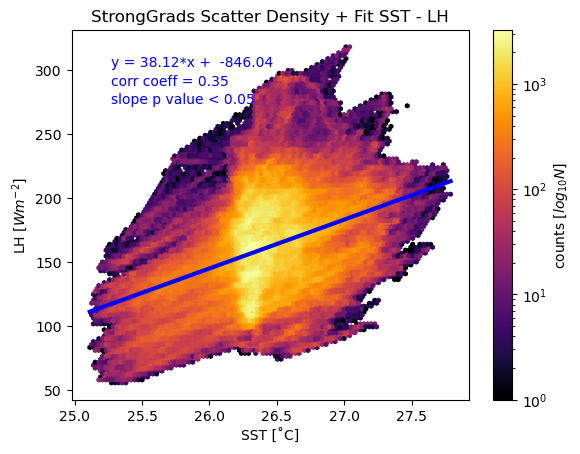

In [28]:
##### FITTING #####

# # corr length
# L = 80
# nskip = int(L/2)
# nt = int(2)
# nbin = 50
dsst = False

if not dsst:
    x =  (sst_day-273.15).copy()    
    y =  LH.copy()     
    fit, corcoe, p_value, p_value_cannelli, sigma_LHfit = slopes_r_p_mix(x, y, nt, nskip)
    title='StrongGrads Scatter Density + Fit SST - LH'
    xlabel='SST [˚C]'
    ylabel='LH [$Wm^{-2}$]'
    
else:
    x = dsst_day.copy()    #dsst_day[~np.isnan(dsst_day)].copy()       #[::nt,::nskip,::nskip].copy()
    y = dLH.copy()         #dLH[~np.isnan(dLH)].copy()
    fit, corcoe, p_value, p_value_cannelli, sigma_dLHfit = slopes_r_p_mix(x, y, nt, nskip)
    title='StrongGrads Scatter Density + Fit dSST - dLH'
    xlabel='SST anoms [˚C]'
    ylabel=r'LH anoms [$Wm^{-2}$]'
    miny = -150 ; maxy = 100
    minx = -2 ; maxx = 1
    

fig = density_hexbin(x,y,fit=fit,corcoe=corcoe,grdsz=100,\
                     title=title,xlabel=xlabel,ylabel=ylabel, colormap='inferno', pos=[0.1, 0.9])

if dsst:
    plt.vlines(0, ymin=miny, ymax=maxy, color='red', linewidth=1)
    plt.hlines(0, xmin=minx, xmax=maxx, color='red', linewidth=1)
    
if p_value_cannelli < 0.05:
    plt.annotate('slope p value < 0.05', xy=(0.1, 0.8), \
                         xycoords='axes fraction', fontsize=10, color='b')
else:
    plt.annotate('slope p value > 0.05', xy=(0.1, 0.8), \
                         xycoords='axes fraction', fontsize=10, color='b')

    

path_img = '/venus/tesi_ale/img_EU/LH/daily/FEB/' 
filename = path_img + 'scatterFIT_dsst_dLH_feb_strongGrads.png' if dsst else path_img + 'scatterFIT_sst_LH_feb_strongGrads.png'
#plt.savefig(filename)
print(filename)
del filename

In [ ]:
#########    HFX     #########

In [12]:
# dSST vs dHFX
pdist_x, pdist_dHFX, pstd_dHFX, pstderr_dHFX, pnpoints_dHFX, ppvalue_dHFX =   distrib_2d(dsst_day, dHFX, perc_step, nbins, popmean, perc_fixbin='perc')
#dist_x, dist_dHFX, std_dHFX, stderr_dHFX, npoints_dHFX, pvalue_dHFX       =   distrib_2d(dsst_day, dHFX, perc_step, nbins, popmean, perc_fixbin='fb')

In [13]:
# SST vs HFX
pdist_sst, pdist_HFX, pstd_HFX, pstderr_HFX, pnpoints_HFX, ppvalue_HFX =   distrib_2d(sst_day, HFX, perc_step, nbins, popmean, perc_fixbin='perc')
#dist_sst, dist_HFX, std_HFX, stderr_HFX, npoints_HFX, pvalue_HFX       =   distrib_2d(sst_day, HFX, perc_step, nbins, popmean, perc_fixbin='fb')

NameError: name 'sst_day' is not defined

In [64]:
p_sst = [pdist_x, pdist_dHFX, pstd_dHFX, pstderr_dHFX, pnpoints_dHFX, ppvalue_dHFX]
my_save_data('/venus/tesi_ale/data_EU/HFX/daily/FEB/pdist_dsst_dHFX_day_feb.npy', p_sst)

file already exists - DELETING IT and creating it anew


/venus/tesi_ale/img_EU/HFX/daily/FEB/scatterFIT_sst_HFX_feb.png


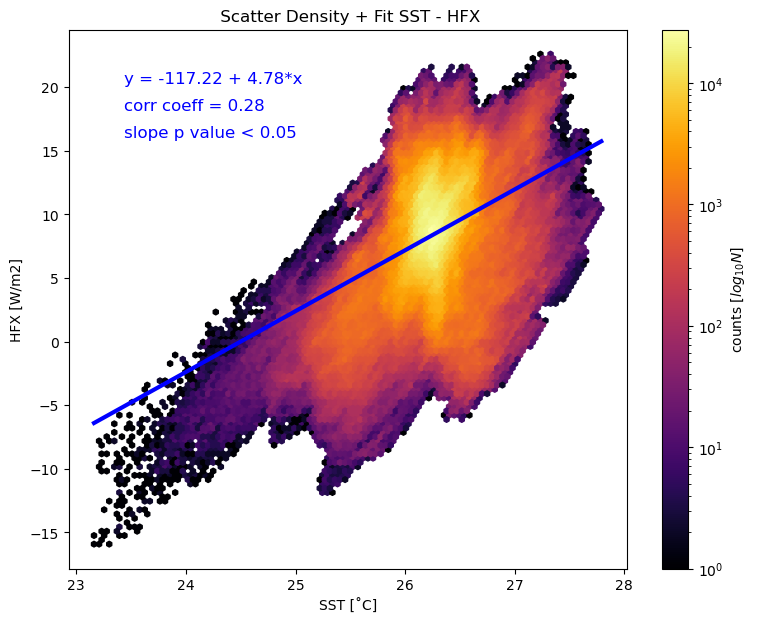

In [26]:
##### FITTING #####

# # corr length
# L = 80
# nskip = int(L/2)
# nt = int(2)
# nbin = 50
dsst = False

if not dsst:
    x = (sst_day-273.15).copy()       #[::nt,::nskip,::nskip].copy()
    y = HFX.copy()
    fit_hfx, corcoe_hfx, p_value_hfx, t_value_cannelli_hfx, p_value_cannelli_hfx = slopes_r_p_mix(x, y, nt, nskip)
    title=' Scatter Density + Fit SST - HFX'
    xlabel='SST [˚C]'
    ylabel='HFX [W/m2]'
else:
    x = dsst_day.copy()       #[::nt,::nskip,::nskip].copy()
    y = dHFX.copy()
    fit_hfx, corcoe_hfx, p_value_hfx, t_value_cannelli_hfx, p_value_cannelli_hfx = slopes_r_p_mix(x, y, nt, nskip)
    title='Scatter Density + Fit dSST - dHFX'
    xlabel='SST anoms [˚C]'
    ylabel='HFX anoms [W/m2]'
    miny = -20 ; maxy = -miny
    minx = -2 ; maxx = 1


fig = density_hexbin(x,y,fit=fit_hfx,corcoe=corcoe_hfx,grdsz=100,title=title,xlabel=xlabel,ylabel=ylabel, colormap='inferno')
    
    
'''fig1 = scatterplot_fit(x, y, fit, title, xlabel, ylabel, fig)
plt.annotate('corr coeff = '+str(round(corcoe,2)), xy=(0.1, 0.85), \
                     xycoords='axes fraction', fontsize=12, color='orange')'''
if dsst:
    plt.vlines(0, ymin=miny, ymax=maxy, color='red', linewidth=1)
    plt.hlines(0, xmin=minx, xmax=maxx, color='red', linewidth=1)
    
    
if p_value_cannelli_hfx < 0.05:
    plt.annotate('slope p value < 0.05', xy=(0.1, 0.8), \
                         xycoords='axes fraction', fontsize=12, color='b')
else:
    plt.annotate('slope p value > 0.05', xy=(0.1, 0.8), \
                         xycoords='axes fraction', fontsize=12, color='b')


path_img = '/venus/tesi_ale/img_EU/HFX/daily/FEB/' 
filename = path_img + 'scatterFIT_dsst_dHFX_feb.png' if dsst else path_img + 'scatterFIT_sst_HFX_feb.png'
# plt.savefig(filename)
print(filename)
del filename

# FIT FOR SENSIBLE HEAT COEFFICIENT

In [ ]:
#### HFX fit to estimate C_sh in bulk formulation
#### HSB = rho*cp*C_sh*U10*(SSt-T2)

In [18]:
#############    THERMODYNAMIC CONTRIBUTION TO dLH/dSST?

q2_day = ds_hourly['Q2'].sel(time_counter=slice('2020-02-01T01:30:00.000000000', '2020-03-01T01:30:00.000000000'))
q2_day = q2_day.groupby('time_counter.day').mean()
q2_day = q2_day.where(sea_mask, drop=False).values;

In [22]:
# retrieving pressure field

pres_base = xr.open_dataset(wrf_files[files_ls.index('PB.nc')])
pres_base = pres_base['PB']
# pres_base = pres_base[0,:,:]

pres = xr.open_dataset(wrf_files[files_ls.index('P.nc')]);  pres = pres['P']
pres = pres.sel(time_counter=slice('2020-02-01T01:30:00.000000000', '2020-03-01T01:30:00.000000000'))
pres = (pres+pres_base)/100.
#pres = pres.groupby('time_counter.day').mean()


pres = pres.where(sea_mask, drop=False)


del pres_base

# retrieving pressure at surface level
pres_sfc = pres[:,0,:,:]
pres_sfc = pres_sfc.groupby('time_counter.day').mean()

del pres

In [19]:
U = np.load('/venus/tesi_ale/data_EU/WIND/daily/FEB/U/U_day_feb.npy')
V = np.load('/venus/tesi_ale/data_EU/WIND/daily/FEB/V/V_day_feb.npy')

ws = np.sqrt(U**2+V**2)

# I KNOW THIS IS WRONG, I SHOULD CORRECT IT FOR THE LOG PROFILE
ws_10 = (ws[:,0,:,:]+ws[:,1,:,:])*0.5 

del U, V, ws

In [23]:
## trying to estimate air density, see if ths changes the estimate of C
T_virt = (T2*units.kelvin)*(1+0.61*q2_day*units('kg/kg'))
Rd = 287.058
rho_air = pres_sfc*100/(Rd*T_virt.magnitude)   # pressure is in hPa

In [24]:
cp = 1004.67

ingredients = rho_air*cp*ws_10*(sst_day-T2)

/venus/tesi_ale/img_EU/HFX/daily/FEB/scatterFIT_Csh_feb.png


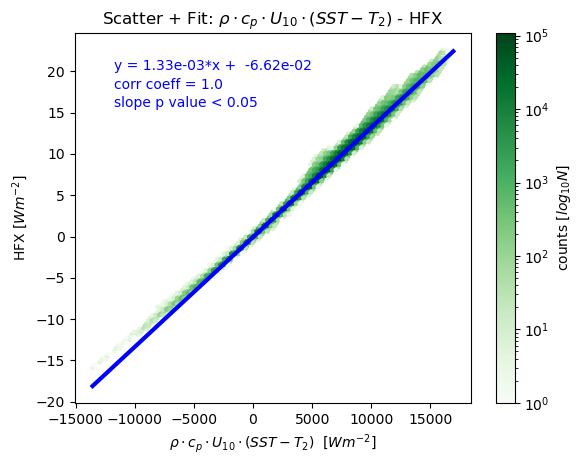

In [35]:
# FIT FOR  SH  C

x = ingredients.values.copy()  
y = HFX.copy()

fit_Csh, corcoe_Csh, p_value_Csh, p_val_cann_Csh, sigmas_coeffs_Csh = slopes_r_p_mix(x, y, nt, nskip)

title=r'Scatter + Fit: $\rho \cdot c_p \cdot U_{10} \cdot \left( SST - T_2  \right) $ - HFX'
xlabel=r'$\rho \cdot c_p \cdot U_{10} \cdot \left( SST - T_2  \right)$  [$Wm^{-2}$]'
ylabel='HFX [$Wm^{-2}$]'

#plt.xticks([25*(10**3), 50*(10**3), 75*(10**3), 100*(10**3), 125*(10**3), 150*(10**3), 175*(10**3),200*(10**3), 225*(10**3)],\
#           ['25', '50', '75', '100', '125', '150','175', '200', '225'])  
 

fig = density_hexbin(x, y, fit=fit_Csh, corcoe=corcoe_Csh, grdsz=100,\
                     title=title, xlabel=xlabel, ylabel=ylabel, colormap='Greens', pos=(0.1,0.9))


if p_val_cann_Csh < 0.05:
    plt.annotate('slope p value < 0.05', xy=(0.1, 0.8), \
                         xycoords='axes fraction', fontsize=10, color='b')
else:
    plt.annotate('slope p value > 0.05', xy=(0.1, 0.8), \
                         xycoords='axes fraction', fontsize=10, color='b')
    
path_img = '/venus/tesi_ale/img_EU/HFX/daily/FEB/' 
filename = path_img + 'scatterFIT_Csh_feb.png'
#plt.savefig(filename)
print(filename)
del filename

In [ ]:
#########    PBLH     #########

In [42]:
# dSST vs dPBLH
pdist_x, pdist_dPBLH, pstd_dPBLH, pstderr_dPBLH, pnpoints_dPBLH, ppvalue_dPBLH =   distrib_2d(dsst_day, dPBLH_day, perc_step, nbins, popmean, perc_fixbin='perc')
dist_x, dist_dPBLH, std_dPBLH, stderr_dPBLH, npoints_dPBLH, pvalue_dPBLH       =   distrib_2d(dsst_day, dPBLH_day, perc_step, nbins, popmean, perc_fixbin='fb')


In [45]:
# dSST vs PBLH
pdist_x, pdist_PBLH, pstd_PBLH, pstderr_PBLH, pnpoints_PBLH, ppvalue_PBLH =   distrib_2d(x, PBLH_day, perc_step, nbins, popmean, perc_fixbin='perc')
dist_x, dist_PBLH, std_PBLH, stderr_PBLH, npoints_PBLH, pvalue_PBLH       =   distrib_2d(x, PBLH_day, perc_step, nbins, popmean, perc_fixbin='fb')

In [ ]:
#### PLOTTING

one side probability for X2 > Xo2 = 0.9999998732574135 

/venus/tesi_ale/img_EU/LH/daily/FEB/scatterFIT_dsst_dLH_distribs.png


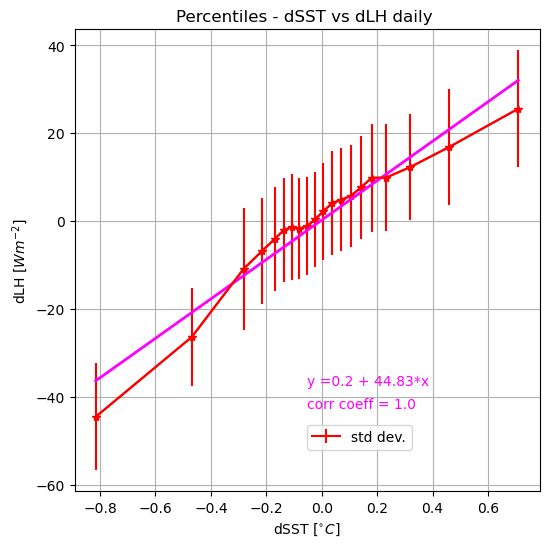

In [30]:
# dist_x vs dLH

full = False
from scipy.stats import chi2


fig, ax1 = plt.subplots(1, 1, figsize=(6, 6))

title = 'SST vs LH daily' if full else 'dSST vs dLH daily'
xlabel = 'SST [$^{\circ}C$]' if full else 'dSST [$^{\circ}C$]'
ylabel = 'LH [$Wm^{-2}$]' if full else 'dLH [$Wm^{-2}$]'

x_p = pdist_sst-273.15 if full else pdist_x 
var_p = pdist_LH if full else pdist_dLH
std_p = pstd_LH if full else pstd_dLH

fit_p, corcoe_p, p_value_p, p_chisq, p_prob_chisq_grt, p_chisq_rid = slopes_r_p(x_p,var_p, std_p)

p1 = ax1.plot(x_p, var_p, '*-r') 
ax1.plot(x_p, fit_p.slope*x_p + fit_p.intercept, color='magenta', linewidth=2)
ax1.errorbar(x_p, var_p, yerr=std_p, xerr=None, color='r', label='std dev.')
ax1.set_xlabel(xlabel)
ax1.set_ylabel(ylabel)
ax1.set_title(f'Percentiles - {title} '); # ax1.grid()

ax1.annotate('y =' + str(round(fit_p.intercept, 2)) + ' + ' + str(round(fit_p.slope, 2)) + '*x', xy=(0.5, 0.23), \
                     xycoords='axes fraction', fontsize=10, color='magenta')
ax1.annotate('corr coeff = '+str(round(corcoe_p,2)), xy=(0.5, 0.18), \
                     xycoords='axes fraction', fontsize=10, color='magenta')
ax1.legend(loc='lower right', bbox_to_anchor=(0.74, 0.075))

ax1.grid()

# cumulative probability of chi2
print(f'one side probability for X2 > Xo2 = {p_prob_chisq_grt} \n')

path_img = '/venus/tesi_ale/img_EU/LH/daily/FEB/' 
filename = path_img + 'scatterFIT_sst_LH_distribs.png' if full else path_img + 'scatterFIT_dsst_dLH_distribs.png'
#plt.savefig(filename)
print(filename)
del filename

In [44]:
np.sum(  (var_p-fit_p.slope*x_p-fit_p.intercept)**2 / pstd_dLH**2 )

0.8083325469398234

one side probability for X2 > Xo2 = 0.999999796482727 

/venus/tesi_ale/img_EU/HFX/daily/FEB/scatterFIT_sst_HFX_distribs.png


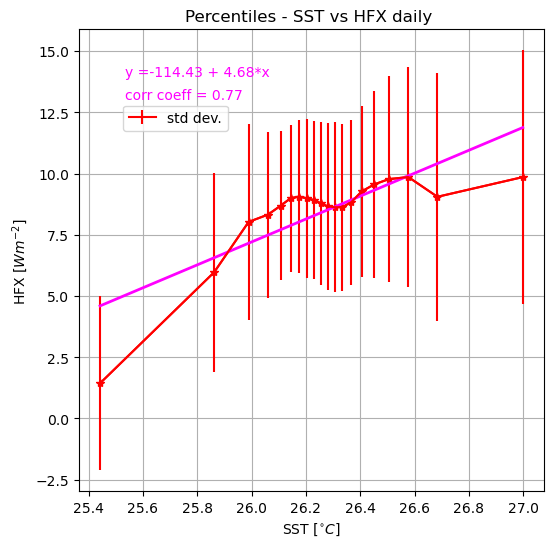

In [34]:
# dist_x vs dHFX

full = True



fig, ax1 = plt.subplots(1, 1, figsize=(6, 6))

title = 'SST vs HFX daily' if full else 'dSST vs dHFX daily'
xlabel = 'SST [$^{\circ}C$]' if full else 'dSST [$^{\circ}C$]'
ylabel = 'HFX [$Wm^{-2}$]' if full else 'dHFX [$Wm^{-2}$]'

x_p = pdist_sst-273.15 if full else pdist_x 
var_p = pdist_HFX if full else pdist_dHFX
std_p = pstd_HFX if full else pstd_dHFX

fit_p_hfx, corcoe_p_hfx, p_value_p_hfx, p_chisq_hfx, p_prob_chisq_grt_hfx, p_chisq_rid_hfx = slopes_r_p(x_p,var_p, std_p)

p1 = ax1.plot(x_p, var_p, '*-r') 
ax1.plot(x_p, fit_p_hfx.slope*x_p + fit_p_hfx.intercept, color='magenta', linewidth=2)
ax1.errorbar(x_p, var_p, yerr=std_p, xerr=None, color='r', label='std dev.')
ax1.set_xlabel(xlabel)
ax1.set_ylabel(ylabel)
ax1.set_title(f'Percentiles - {title} '); # ax1.grid()

ax1.annotate('y =' + str(round(fit_p_hfx.intercept, 2)) + ' + ' + str(round(fit_p_hfx.slope, 2)) + '*x', xy=(0.1, 0.9), \
                     xycoords='axes fraction', fontsize=10, color='magenta')
ax1.annotate('corr coeff = '+str(round(corcoe_p_hfx,2)), xy=(0.1, 0.85), \
                     xycoords='axes fraction', fontsize=10, color='magenta')
ax1.legend(loc='upper left', bbox_to_anchor=(0.08, 0.85))


ax1.grid()

# cumulative probability of chi2
print(f'one side probability for X2 > Xo2 = {p_prob_chisq_grt_hfx} \n')




path_img = '/venus/tesi_ale/img_EU/HFX/daily/FEB/' 
filename = path_img + 'scatterFIT_sst_HFX_distribs.png' if full else path_img + 'scatterFIT_dsst_dHFX_distribs.png'
# plt.savefig(filename)
print(filename)
del filename

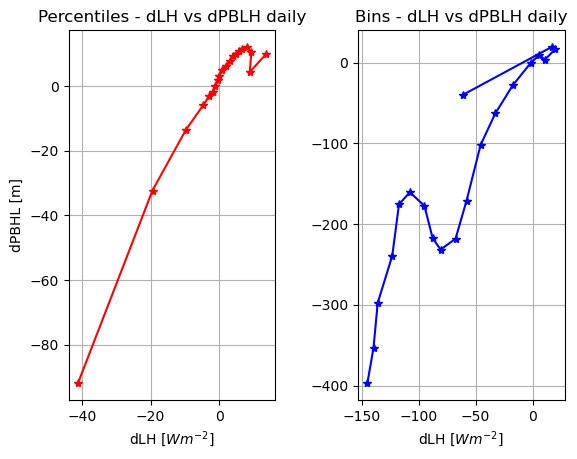

In [43]:
# dLH vs dPBLH

fig, (ax1, ax2) = plt.subplots(1, 2)

p1 = ax1.plot(pdist_dLH, pdist_dPBLH, '*-r')
ax1.set_xlabel('dLH [$Wm^{-2}$]')
ax1.set_ylabel('dPBHL [m]')
ax1.set_title('Percentiles - dLH vs dPBLH daily'); ax1.grid()

p2 = ax2.plot(dist_dLH, dist_dPBLH, '*-b')
ax2.set_xlabel('dLH [$Wm^{-2}$]')
ax2.set_title('Bins - dLH vs dPBLH daily'); ax2.grid()


plt.subplots_adjust(wspace=0.4, 
                    hspace=0.3)

In [17]:
#############    THERMODYNAMIC CONTRIBUTION TO dLH/dSST?

q2_day = ds_hourly['Q2'].sel(time_counter=slice('2020-02-01T01:30:00.000000000', '2020-03-01T01:30:00.000000000'))
q2_day = q2_day.groupby('time_counter.day').mean()
q2_day = q2_day.where(sea_mask, drop=False).values;

In [31]:
# retrieving pressure field

pres_base = xr.open_dataset(wrf_files[files_ls.index('PB.nc')])
pres_base = pres_base['PB']
# pres_base = pres_base[0,:,:]

pres = xr.open_dataset(wrf_files[files_ls.index('P.nc')]);  pres = pres['P']
pres = pres.sel(time_counter=slice('2020-02-01T01:30:00.000000000', '2020-03-01T01:30:00.000000000'))
pres = (pres+pres_base)/100.
#pres = pres.groupby('time_counter.day').mean()


pres = pres.where(sg_mask, drop=False)


del pres_base


In [32]:
# retrieving pressure at surface level
pres_sfc = pres[:,0,:,:]
pres_sfc = pres_sfc.where(sg_mask, drop=False)
pres_sfc = pres_sfc.groupby('time_counter.day').mean()

del pres

In [ ]:
## compute saturation vapour pressure

In [15]:
#qsat = mpcalc.saturation_mixing_ratio(pres_sfc*units.hPa,T2*units.K).to('kg/kg')
#qsat = qsat/(1+qsat)    # from ratio to specific

In [9]:
qsat_sst = np.load('/venus/tesi_ale/data_EU/QVAPOR/daily/FEB/qsat_sst_day.npy')
dqsat_sst = np.load('/venus/tesi_ale/data_EU/QVAPOR/daily/FEB/dqsat_sst_day.npy')

In [11]:
delta_q = qsat_sst*units('g/kg') - q2_day*units('kg/kg') ;   delta_q = delta_q.to('g/kg')

In [29]:
my_save_data('/venus/tesi_ale/data_EU/QVAPOR/daily/FEB/deltaQ_day_feb.npy', [delta_q.magnitude])

file already exists - DELETING IT and creating it anew


In [10]:
delta_q = np.load('/venus/tesi_ale/data_EU/QVAPOR/daily/FEB/deltaQ_day_feb.npy')

In [11]:
qsat_2m = np.load('/venus/tesi_ale/data_EU/QVAPOR/daily/FEB/qsat_2m_day.npy')
dqsat_2m = np.load('/venus/tesi_ale/data_EU/QVAPOR/daily/FEB/dqsat_2m_day.npy')

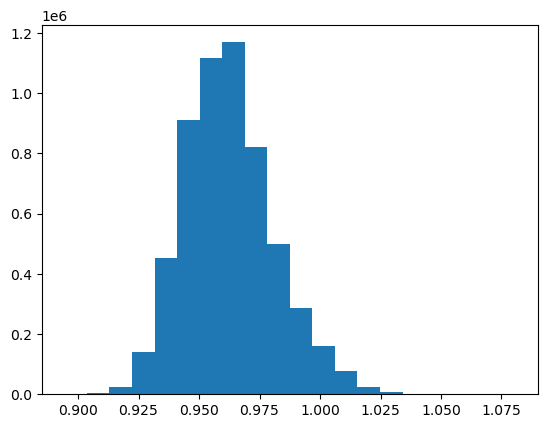

In [12]:
plt.hist(qsat_2m[~np.isnan(qsat_2m)]/qsat_sst[~np.isnan(qsat_sst)], bins=20)
plt.title(r'$qsat_{2m}/qsat_{sst}$')
plt.show()

(array([2.200000e+01, 1.170000e+02, 5.940000e+02, 6.169000e+03,
        3.001200e+04, 9.983300e+04, 3.281890e+05, 6.580750e+05,
        9.085720e+05, 1.227301e+06, 1.026047e+06, 5.742200e+05,
        3.270840e+05, 1.818860e+05, 1.124280e+05, 8.897500e+04,
        6.399200e+04, 3.713700e+04, 2.020500e+04, 3.031000e+03]),
 array([18.45053211, 18.65018439, 18.84983666, 19.04948894, 19.24914122,
        19.44879349, 19.64844577, 19.84809805, 20.04775032, 20.2474026 ,
        20.44705488, 20.64670715, 20.84635943, 21.04601171, 21.24566399,
        21.44531626, 21.64496854, 21.84462082, 22.04427309, 22.24392537,
        22.44357765]),
 <BarContainer object of 20 artists>)

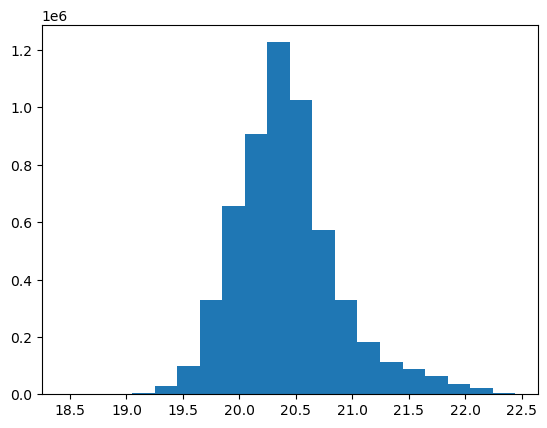

In [59]:
plt.hist(qsat_2m[~np.isnan(qsat_2m)], bins=20)
plt.title(r'$qsat_{2m}$')
plt.show()

(array([5.500000e+01, 9.100000e+01, 2.950000e+02, 7.470000e+02,
        1.305000e+03, 2.269000e+03, 6.982000e+03, 1.703600e+04,
        5.893000e+04, 1.371980e+05, 1.839190e+05, 8.098600e+05,
        2.145314e+06, 1.481786e+06, 5.128280e+05, 1.816730e+05,
        1.019170e+05, 4.401500e+04, 6.570000e+03, 1.099000e+03]),
 array([17.58691025, 17.87075338, 18.15459652, 18.43843966, 18.72228279,
        19.00612593, 19.28996906, 19.5738122 , 19.85765533, 20.14149847,
        20.42534161, 20.70918474, 20.99302788, 21.27687101, 21.56071415,
        21.84455729, 22.12840042, 22.41224356, 22.69608669, 22.97992983,
        23.26377296]),
 <BarContainer object of 20 artists>)

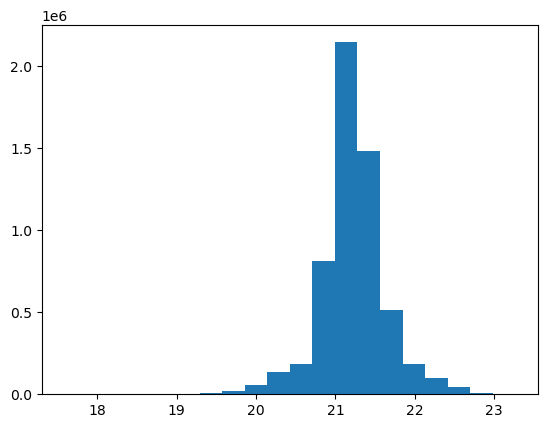

In [57]:
plt.hist(qsat_sst[~np.isnan(qsat_sst)], bins=20)
plt.title(r'$qsat_{sst}$')
plt.show()

(array([  5008.,  14888.,  45360.,  70714., 171323., 285781., 526573.,
        618616., 692106., 852720., 694816., 594288., 436565., 256720.,
        246770., 121319.,  39603.,  15165.,   2718.,   2836.]),
 array([0.01377331, 0.01405569, 0.01433806, 0.01462043, 0.0149028 ,
        0.01518517, 0.01546754, 0.01574991, 0.01603228, 0.01631465,
        0.01659702, 0.01687939, 0.01716176, 0.01744413, 0.01772651,
        0.01800888, 0.01829125, 0.01857362, 0.01885599, 0.01913836,
        0.01942073], dtype=float32),
 <BarContainer object of 20 artists>)

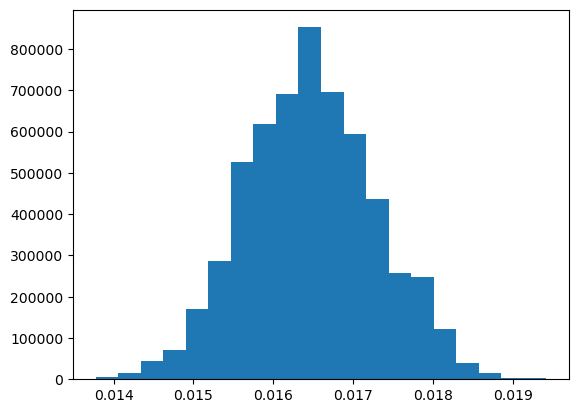

In [63]:
plt.hist(q2_day[~np.isnan(q2_day)], bins=20)
plt.title(r'$q2_{day}$')
plt.show()

In [47]:
s = 100

d_delta_q = np.zeros(delta_q.shape)

for t in range(0,delta_q.shape[0]):
    if t % 10 == 0:
        print(t)
    # upscale using gaussian filter
    dq_ave = gm.nan_gaussian_filter(delta_q[t].magnitude,s)                             
    d_delta_q[t] = delta_q[t].magnitude - dq_ave

0
10
20


In [48]:
my_save_data('/venus/tesi_ale/data_EU/QVAPOR/daily/FEB/DdeltaQ_day_feb.npy', [d_delta_q])

file already exists - DELETING IT and creating it anew


In [13]:
d_delta_q = np.load('/venus/tesi_ale/data_EU/QVAPOR/daily/FEB/DdeltaQ_day_feb.npy')

In [37]:
s = 100

#dqsat = np.zeros(qsat.shape)
dq2 = np.zeros(q2_day.shape)

for t in range(0,q2_day.shape[0]):
    if t % 10 == 0:
        print(t)
    # upscale using gaussian filter
    '''qsat_ave = gm.nan_gaussian_filter(qsat[t].magnitude,s)                             
    dqsat[t] = qsat[t].magnitude - qsat_ave'''
    
    dq_ave = gm.nan_gaussian_filter(q2_day[t],s)                             
    dq2[t] = q2_day[t] - dq_ave

0
10
20


In [38]:
my_save_data('/venus/tesi_ale/data_EU/QVAPOR/daily/FEB/dq2_day_feb.npy', [dq2])

In [14]:
dq2 = np.load('/venus/tesi_ale/data_EU/QVAPOR/daily/FEB/dq2_day_feb.npy')

In [21]:
s = 100

dT2 = np.zeros(T2.shape)

for t in range(0,T2.shape[0]):
    if t % 10 == 0:
        print(t)
    # upscale using gaussian filter
    t2_mean = gm.nan_gaussian_filter(T2[t],s)                             
    dT2[t] = T2[t] - t2_mean
    

0
10
20


/venus/tesi_ale/img_EU/T/daily/FEB/scatterFIT_T2-sst_dT2-dsst_feb.png


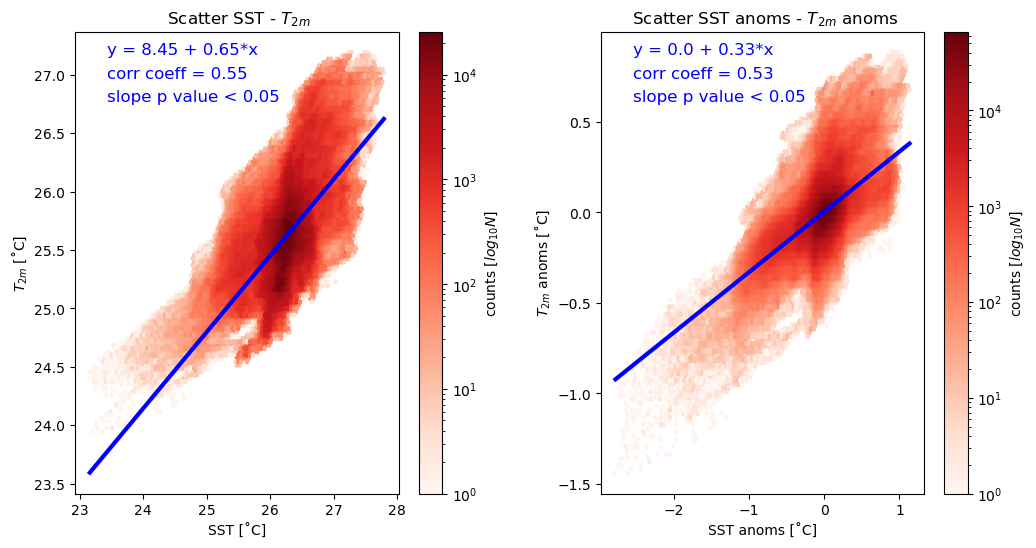

In [31]:
#####  LINKING T2 WITH SST


# variaiton of qsat and q2 with SST and dSST
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,6))

anoms = False

x =  sst_day-273.15
y =  T2-273.15
fit_T2_sst, corcoe_T2_sst, p_value_T2_sst, p_value_cannelli_T2_sst, sigmas_coeffs_T2_sst = slopes_r_p_mix(x, y, nt, nskip)
   
density_hexbin_subplots(x, y, fit=fit_T2_sst, corcoe=corcoe_T2_sst, grdsz=100, fig=fig, ax=ax1,\
                        title=' Scatter SST - $T_{2m}$', xlabel='SST [˚C]', ylabel='$T_{2m}$ [˚C]', colormap='Reds')
    

    
if p_value_cannelli_T2_sst < 0.05:
    ax1.annotate('slope p value < 0.05', xy=(0.1, 0.85), \
                         xycoords='axes fraction', fontsize=12, color='b')
else:
    ax1.annotate('slope p value > 0.05', xy=(0.1, 0.85), \
                         xycoords='axes fraction', fontsize=12, color='b')
    
    

    
    
    
xx = dsst_day
yy = dT2 
fit_dT2_dsst, corcoe_dT2_dsst, p_value_dT2_dsst, p_value_cannelli_dT2_dsst, sigmas_coeffs_dT2_dsst = slopes_r_p_mix(xx, yy, nt, nskip)
# ls_therm_contr = fit_qsat_sst.slope

density_hexbin_subplots(xx, yy, fit=fit_dT2_dsst, corcoe=corcoe_dT2_dsst, grdsz=100, fig=fig, ax=ax2,\
                        title=' Scatter SST anoms - $T_{2m}$ anoms', xlabel='SST anoms [˚C]', ylabel='$T_{2m}$ anoms [˚C]', colormap='Reds')




if p_value_cannelli_dT2_dsst < 0.05:
    ax2.annotate('slope p value < 0.05', xy=(0.1, 0.85), \
                         xycoords='axes fraction', fontsize=12, color='b')
else:
    ax2.annotate('slope p value > 0.05', xy=(0.1, 0.85), \
                         xycoords='axes fraction', fontsize=12, color='b')



plt.subplots_adjust(wspace=0.3, 
                    hspace=0.4)

path_img = '/venus/tesi_ale/img_EU/T/daily/FEB/' 
filename = path_img + 'scatterFIT_T2-sst_dT2-dsst_feb.png' # if dsst else path_img + 'scatterFIT_sst_DELTAQ_feb.png'
# plt.savefig(filename)
print(filename)
del filename

/venus/tesi_ale/img_EU/THERM_CONTR/daily/FEB/scatterFIT_dsst_dQsat_dQ2_feb.png


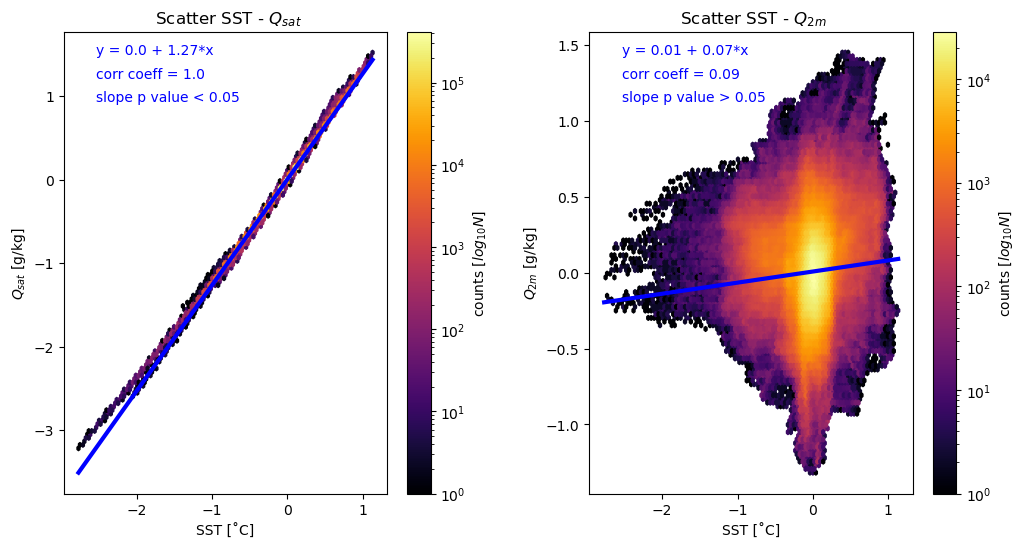

In [53]:
# variaiton of qsat and q2 with SST and dSST
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,6))

anoms = True

x = dsst_day if anoms else (sst_day-273.15)
y = dqsat_sst if anoms else qsat_sst
fit_qsat_sst, corcoe_qsat, p_value_qsat, p_value_cannelli_qsat, sigmas_coeffs_qsat = slopes_r_p_mix(x, y, nt, nskip)
# ls_therm_contr = fit_qsat_sst.slope
   
density_hexbin_subplots(x, y, fit=fit_qsat_sst, corcoe=corcoe_qsat, grdsz=100, fig=fig, ax=ax1,\
                        title=' Scatter SST - $Q_{sat}$', xlabel='SST [˚C]', ylabel='$Q_{sat}$ [g/kg]', colormap='inferno')
    

if p_value_cannelli_qsat < 0.05:
    ax1.annotate('slope p value < 0.05', xy=(0.1, 0.85), \
                         xycoords='axes fraction', fontsize=10, color='b')
else:
    ax1.annotate('slope p value > 0.05', xy=(0.1, 0.85), \
                         xycoords='axes fraction', fontsize=10, color='b')
    
    
xx = x
yy = dq2*1000. if anoms else q2_day*1000.
fit_q2_sst, corcoe_q2, p_value_q2, p_value_cannelli_q2, sigmas_coeffs_q2 = slopes_r_p_mix(xx, yy, nt, nskip)
# ls_therm_contr = fit_qsat_sst.slope

density_hexbin_subplots(xx, yy, fit=fit_q2_sst, corcoe=corcoe_q2, grdsz=100, fig=fig, ax=ax2,\
                        title=' Scatter SST - $Q_{2m}$', xlabel='SST [˚C]', ylabel='$Q_{2m}$ [g/kg]', colormap='inferno')


if p_value_cannelli_q2 < 0.05:
    ax2.annotate('slope p value < 0.05', xy=(0.1, 0.85), \
                         xycoords='axes fraction', fontsize=10, color='b')
else:
    ax2.annotate('slope p value > 0.05', xy=(0.1, 0.85), \
                         xycoords='axes fraction', fontsize=10, color='b')


    

plt.subplots_adjust(wspace=0.3, 
                    hspace=0.4)


######  PREVIOUSLY SAVED IN QVAPOR  #######
path_img = '/venus/tesi_ale/img_EU/THERM_CONTR/daily/FEB/' 
filename = path_img + 'scatterFIT_dsst_dQsat_dQ2_feb.png' if anoms else path_img + 'scatterFIT_sst_Qsat_Q2_feb.png'
#plt.savefig(filename)
print(filename)
del filename
######  PREVIOUSLY SAVED IN QVAPOR  #######

/venus/tesi_ale/img_EU/THERM_CONTR/daily/FEB/scatterFIT_dsst_dDELTAQ_feb.png


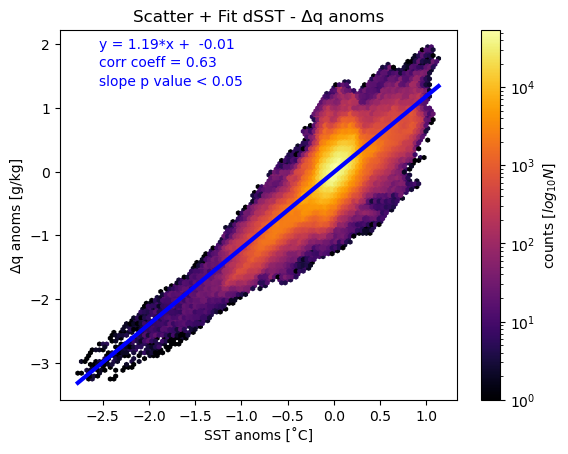

In [51]:
##### FITTING #####

# # corr length
# L = 80
# nskip = int(L/2)
# nt = int(2)
# nbin = 50
dsst = True

if not dsst:
    x = (sst_day-273.15).copy()      
    y = delta_q.copy()
    fit_dq_sst, corcoe_dq, p_value_dq, p_value_cannelli_dq, sigmas_coeffs_dq = slopes_r_p_mix(x, y, nt, nskip)
    ls_therm_contr = fit_dq_sst.slope
    
    title=' Scatter + Fit SST - Δq'
    xlabel='SST [˚C]'
    ylabel='Δq [g/kg]'
    fig = density_hexbin(x,y,fit=fit_dq_sst,corcoe=corcoe_dq,grdsz=100,title=title,xlabel=xlabel,ylabel=ylabel, colormap='inferno')
else:
    x = dsst_day.copy()       
    y = d_delta_q.copy()
    fit_dq_dsst, corcoe_dq, p_value_dq, p_value_cannelli_dq, sigmas_coeffs_dq  = slopes_r_p_mix(x, y, nt, nskip)
    ss_therm_contr = fit_dq_dsst.slope
    
    title='Scatter + Fit dSST - Δq anoms'
    xlabel='SST anoms [˚C]'
    ylabel='Δq anoms [g/kg]'
    fig = density_hexbin(x,y,fit=fit_dq_dsst,corcoe=corcoe_dq,grdsz=100,title=title,xlabel=xlabel,ylabel=ylabel, colormap='inferno')
    

    
if p_value_cannelli_dq < 0.05:
    plt.annotate('slope p value < 0.05', xy=(0.1, 0.85), \
                         xycoords='axes fraction', fontsize=10, color='b')
else:
    plt.annotate('slope p value > 0.05', xy=(0.1, 0.85), \
                         xycoords='axes fraction', fontsize=10, color='b')


    

######  PREVIOUSLY SAVED IN QVAPOR  #######    
path_img = '/venus/tesi_ale/img_EU/THERM_CONTR/daily/FEB/' 
filename = path_img + 'scatterFIT_dsst_dDELTAQ_feb.png' if dsst else path_img + 'scatterFIT_sst_DELTAQ_feb.png'
#plt.savefig(filename)
print(filename)
del filename
######  PREVIOUSLY SAVED IN QVAPOR  #######

In [ ]:
###### trying to estimate aerodynamic coefficient

In [19]:
U = np.load('/venus/tesi_ale/data_EU/WIND/daily/FEB/U/U_day_feb.npy')
V = np.load('/venus/tesi_ale/data_EU/WIND/daily/FEB/V/V_day_feb.npy')

ws = np.sqrt(U**2+V**2)

# I KNOW THIS IS WRONG, I SHOULD CORRECT IT FOR THE LOG PROFILE
ws_10 = (ws[:,0,:,:]+ws[:,1,:,:])*0.5 

del U, V, ws

In [30]:
## trying to estimate air density, see if ths changes the estimate of C
T_virt = (T2*units.kelvin)*(1+0.61*q2_day*units('kg/kg'))
Rd = 287.058
rho_air = pres_sfc*100/(Rd*T_virt.magnitude)   # pressure is in hPa

In [31]:
L_v = 2.5008991412E+03  # units = J/kg  ; function in meteo.py is a correction of order 10^4/10^6 = 10^-2

ingredients = L_v*ws_10*(delta_q) # units = J/kg * m/s
ingredients_rho = rho_air*L_v*ws_10*(delta_q) #  # units = W/m2

/venus/tesi_ale/img_EU/THERM_CONTR/daily/FEB/scatterFIT_C_feb.png


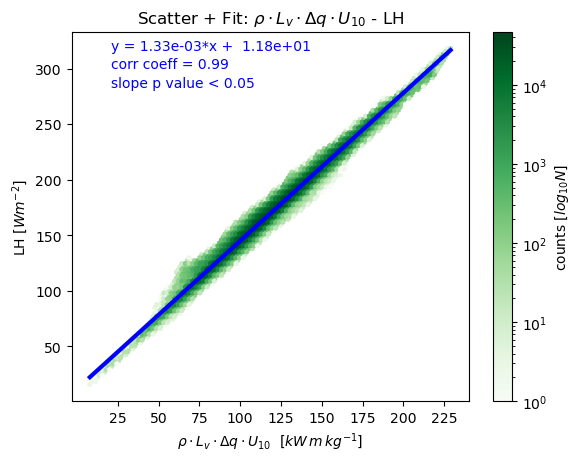

In [48]:
# FIT FOR    C

x = ingredients_rho.values.copy()  
y = LH.copy()
fit_rho, corcoe_rho, p_value_rho, p_value_cannelli_rho, sigmas_coeffs_rho = slopes_r_p_mix(x, y, nt, nskip)
title=r'Scatter + Fit: $\rho \cdot L_v \cdot \Delta q \cdot U_{10}$ - LH'
xlabel=r'$\rho \cdot L_v \cdot \Delta q \cdot U_{10}$  [$kW \, m \, kg^{-1}$]'
ylabel='LH [$Wm^{-2}$]'

plt.xticks([25*(10**3), 50*(10**3), 75*(10**3), 100*(10**3), 125*(10**3), 150*(10**3), 175*(10**3),200*(10**3), 225*(10**3)],\
           ['25', '50', '75', '100', '125', '150','175', '200', '225'])  
 

fig = density_hexbin(x,y,fit=fit_rho,corcoe=corcoe_rho,grdsz=100,title=title,xlabel=xlabel,ylabel=ylabel, colormap='Greens')


if p_value_cannelli_rho < 0.05:
    plt.annotate('slope p value < 0.05', xy=(0.1, 0.85), \
                         xycoords='axes fraction', fontsize=10, color='b')
else:
    plt.annotate('slope p value > 0.05', xy=(0.1, 0.85), \
                         xycoords='axes fraction', fontsize=10, color='b')
    
path_img = '/venus/tesi_ale/img_EU/THERM_CONTR/daily/FEB/' 
filename = path_img + 'scatterFIT_C_feb.png'
plt.savefig(filename)
print(filename)
del filename

/venus/tesi_ale/img_EU/THERM_CONTR/daily/FEB/scatterFIT_rho-C_feb.png


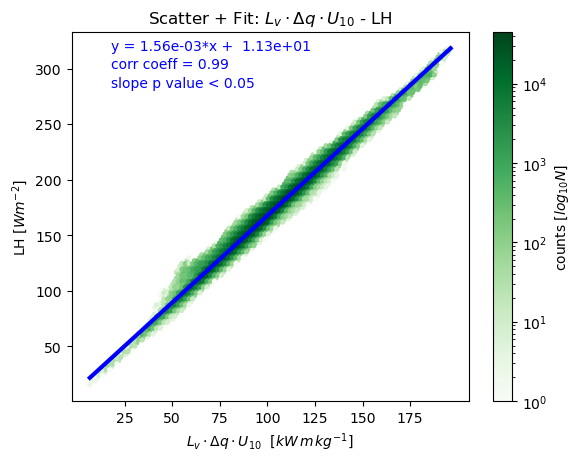

In [47]:
# FIT FOR    rho C

x = ingredients.copy()      # .values if using rho 
y = LH.copy()
fit_lh, corcoe_lh, p_value_lh, p_value_cannelli_lh, sigmas_coeffs_lh = slopes_r_p_mix(x, y, nt, nskip)
title=r'Scatter + Fit: $L_v \cdot \Delta q \cdot U_{10}$ - LH'
xlabel=r'$L_v \cdot \Delta q \cdot U_{10}$  [$kW \, m \, kg^{-1}$]'
ylabel='LH [$Wm^{-2}$]'

plt.xticks([25*(10**3), 50*(10**3), 75*(10**3), 100*(10**3), 125*(10**3), 150*(10**3), 175*(10**3)],\
           ['25', '50', '75', '100', '125', '150','175'])   # 200*(10**3), 225*(10**3)  # , '200', '225'
 

fig = density_hexbin(x,y,fit=fit_lh,corcoe=corcoe_lh,grdsz=100,title=title,xlabel=xlabel,ylabel=ylabel, colormap='Greens')


if p_value_cannelli_lh < 0.05:
    plt.annotate('slope p value < 0.05', xy=(0.1, 0.85), \
                         xycoords='axes fraction', fontsize=10, color='b')
else:
    plt.annotate('slope p value > 0.05', xy=(0.1, 0.85), \
                         xycoords='axes fraction', fontsize=10, color='b')

    
path_img = '/venus/tesi_ale/img_EU/THERM_CONTR/daily/FEB/' 
filename = path_img + 'scatterFIT_rho-C_feb.png'
#plt.savefig(filename)
print(filename)
del filename

In [36]:
rho_C = round(fit_lh.slope, 4);    sigma_rhoC = round(sigmas_coeffs_lh[0], 5)
C = round(fit_rho.slope, 4);       sigma_C = round(sigmas_coeffs_rho[0], 5)

#### RESULT IS VERY MUCH IN LINE WITH VALUE USED BY PABLO!
#### THERE IS ONLY THAT INTERCEPT RUINING THE PARTY

msg = f'C = {C} ± {sigma_C}\nrho_C = {rho_C} ± {sigma_rhoC} \nrelative errors respectively {round(sigma_C/C, 4)} and {sigma_rhoC/rho_C}'
print(msg)

C = 0.0013 ± 1e-05
rho_C = 0.0016 ± 2e-05 
relative errors respectively 0.0077 and 0.0125


In [37]:
# find most frequent thermodyn contr
ws_10_mode = np.mean(ws_10[~np.isnan(ws_10)], axis=None)
rho_mode = np.mean(rho_air.values[~np.isnan(rho_air.values)], axis=None)

In [38]:
print(f'large scale rho_C = {round(rho_C*L_v*ls_therm_contr*(ws_10_mode),3)} W/m2')
print(f'large scale C     = {round((rho_mode)*C*L_v*ls_therm_contr*(ws_10_mode),3)} W/m2')
print('\n')
print(f'small scale rho_C = {round(rho_C*L_v*ss_therm_contr*(ws_10_mode),3)} W/m2')
print(f'small scale C     = {round((rho_mode)*C*L_v*ss_therm_contr*(ws_10_mode),3)} W/m2')

large scale rho_C = 27.717 W/m2
large scale C     = 26.364 W/m2


small scale rho_C = 41.456 W/m2
small scale C     = 39.432 W/m2


In [39]:
data1 = rho_C*L_v*ws_10*ls_therm_contr; data1 = data1[~np.isnan(data1)]
data2 = rho_C*L_v*ws_10*ss_therm_contr; data2 = data2[~np.isnan(data2)]
data3 = C*L_v*ws_10*ls_therm_contr; data3 = data3[~np.isnan(data3)]
data4 = C*L_v*ws_10*ss_therm_contr; data4 = data4[~np.isnan(data4)]


/venus/tesi_ale/img_EU/THERM_CONTR/daily/FEB/violins_full-SS_rho-C_feb.png


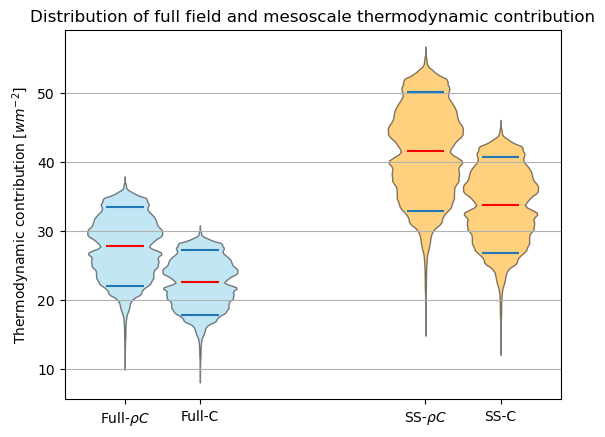

In [57]:
fig, axs = plt.subplots(1,1)
quants = [[0.1, 0.9] , [0.1, 0.9], [0.1, 0.9],[0.1, 0.9]]
pos = [1,1.5,3,3.5]
colorz = ['skyblue', 'skyblue', 'orange', 'orange']



plt.title('Distribution of full field and mesoscale thermodynamic contribution')


####### RHO_C results
# large scale
violin_parts1 = axs.violinplot([data1, data3, data2, data4], positions=pos, showmeans=False, showmedians=True, showextrema=False, quantiles=quants)
violin_parts1['cmedians'].set_color('red')

for pc, color in zip(violin_parts1['bodies'], colorz):
    pc.set_facecolor(color)
    pc.set_edgecolor('black')
    pc.set_alpha(0.5)


axs.yaxis.grid(True)
axs.set_ylabel(r'Thermodynamic contribution [$wm^{-2}$]')

axs.set_xticks(pos)
axs.set_xticklabels([r'Full-$\rho C$','Full-C', r'SS-$\rho C$', 'SS-C'])
axs.set_xlabel('')


path_img = '/venus/tesi_ale/img_EU/THERM_CONTR/daily/FEB/' 
filename = path_img + 'violins_full-SS_rho-C_feb.png' #if dsst else path_img + 'scatterFIT_sst_DELTAQ_feb.png'
#plt.savefig(filename)
print(filename)
del filename